In [ ]:
# yolov5 on official TACO with material as class

# 1. Preparation
 - import dependencies and download data

In [ ]:
!nvidia-smi # check if have computing unit

Mon Mar  6 05:19:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%capture
# install yolov5 on your runtime
%rm -rf /content/*
!git clone https://github.com/ultralytics/yolov5 
%cd yolov5
!pip install -r requirements.txt
!pip install --upgrade albumentations
%cd ..

In [ ]:
# Get TACO dataset
# mount and copy dataset from your google drive

# download TACO from original author's repo https://github.com/pedropro/TACO
# or use https://drive.google.com/file/d/1jxJJmsv_QlSPuiNaHsBohgUsnSB3nz-7/view?usp=share_link

import os
from google.colab import drive
drive.mount('/gdrive',force_remount=True)
if not os.path.isfile('/content/TACO.zip'):
  %cp /gdrive/MyDrive/TACO.zip /content/TACO.zip


# !gdown 1jxJJmsv_QlSPuiNaHsBohgUsnSB3nz-7
# gdown is deprecated: using gdown to access a file too frequently causes the file get restricted by google
# you must mount a copy of TACO to your own google drive

Mounted at /gdrive


In [ ]:
# unzip data, move them 
!unzip -qq ./TACO.zip 
%mkdir -p ./dataset/images/ && mv ./TACO/* ./dataset/images/ && rm -rf ./TACO

In [ ]:
# import dependencies

from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab
from collections import Counter


import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm

import shutil
import copy

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
%%capture
# get annotation (label) file
!wget https://raw.githubusercontent.com/pedropro/TACO/master/data/annotations.json
!wget https://raw.githubusercontent.com/pedropro/TACO/master/data/annotations_unofficial.json

# 2. Data pipeline

## get labels

In [ ]:
# annotation for official TACO (1500 images)
base_anno = './annotations.json'
base_coco_anno = COCO(annotation_file=base_anno)
with open(base_anno, 'r') as f:
    base_anno = json.loads(f.read())


loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


## Reduce label classes

In [ ]:
# material as class
!wget https://raw.githubusercontent.com/running-man-01/utilities/main/material_key.csv

mkey = pd.read_csv('./material_key.csv')
mkey_dict = {i:j for i,j in zip(mkey.cat_id, mkey.m_id)}
mkey[:6]

--2023-03-06 05:20:48--  https://raw.githubusercontent.com/running-man-01/utilities/main/material_key.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1829 (1.8K) [text/plain]
Saving to: ‘material_key.csv’

material_key.csv    100%[===================>]   1.79K  --.-KB/s    in 0s      

2023-03-06 05:20:49 (43.8 MB/s) - ‘material_key.csv’ saved [1829/1829]



,cat_id,category,m_id,material,illustration,illustration_
0,0,Aluminium foil,0,metal,metal,0.0
1,1,Battery,0,metal,plastic,1.0
2,2,Aluminium blister pack,0,metal,glass,2.0
3,3,Carded blister pack,1,plastic,paper,3.0
4,4,Other plastic bottle,1,plastic,other,4.0
5,5,Clear plastic bottle,1,plastic,NaN,NaN


## filter and reorder labels

In [ ]:
bbox_thold =  50*50 # threshold of bbox under which bbox will be discarded for being too small
                    # threshold value = width*height, e.g. 40*40 = 1600 pixels


dst = "./dataset"

%rm -rf ./dataset/labels #reset labels
!mkdir ./dataset/labels

base_imgs = base_anno['images']


counter, skip_counter, obj_counter= 0,0,0
# read every image, assign labels
for img in tqdm(base_imgs):
  height = img['height']
  width = img['width']

  # reorganize images
  img_id = img['id']

  annotation_ids = base_coco_anno.getAnnIds(img_id)

  if len(annotation_ids) == 0:
    # skip images with no annotation
    continue

  with open(dst+'/labels/'+str(img_id)+'.txt', mode='w') as fp:
    annotations = base_coco_anno.loadAnns(annotation_ids)
    lines = ''
    for annotation in annotations:
      obj_counter+=1
      class_ = copy.copy(annotation['category_id'])
      class_ = mkey_dict[class_]
      box = copy.copy(annotation['bbox'])

      # some annotations have basically no width / height (extremely small), skip them
      if box[2] * box[3] < bbox_thold:
        skip_counter+=1 # count number of skippped bbox

        # uncomment below line to see which images have bbox skipped
        # print('bbox too small, skipped. skipped bbox is in image ID:'+ str(img_id))
        continue
      # top_x,top_y,width,height ----> cen_x,cen_y,width,height
      # standardize to 0-1
      box[0] = round((box[0] + box[2] / 2) / width, 6)
      box[1] = round((box[1] + box[3] / 2) / height, 6)
      box[2] = round(box[2] / width, 6)
      box[3] = round(box[3] / height, 6)

      # line: super_id x_center y_center width height
      lines += str(class_)
      for i in box:
        lines += ' ' + str(i)
      lines = lines+ '\n'
    fp.writelines(lines)

  counter+=1


print('\n\nNumber of skipped bbox:' + str(skip_counter) + '\nNumber of all bbox:' + str(obj_counter))


100%|██████████| 1500/1500 [00:00<00:00, 9972.35it/s] 



Number of skipped bbox:876
Number of all bbox:4784


## train test split

In [ ]:
# get iterative stratified split package
!wget https://raw.githubusercontent.com/scikit-multilearn/scikit-multilearn/master/skmultilearn/model_selection/iterative_stratification.py

from iterative_stratification import *

--2023-03-06 05:20:49--  https://raw.githubusercontent.com/scikit-multilearn/scikit-multilearn/master/skmultilearn/model_selection/iterative_stratification.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15708 (15K) [text/plain]
Saving to: ‘iterative_stratification.py’

iterative_stratific 100%[===================>]  15.34K  --.-KB/s    in 0.001s  

2023-03-06 05:20:49 (16.9 MB/s) - ‘iterative_stratification.py’ saved [15708/15708]



In [ ]:
#  check the number of images again
nr_imgs=None
for root, dirnames, filenames in os.walk('./dataset/labels/'):
  nr_imgs = len(filenames)
  break
print('Number of all images:\n'+str(nr_imgs))

nr_class = len(set(mkey_dict.values()))


Number of all images:
1500


In [ ]:
# stratified train/test split

xy = {}
for i in tqdm(range(nr_imgs)):
  try: 
    X = open('./dataset/labels/'+str(i)+'.txt','r')
    lines = X.readlines()
    classes = [int(line.split()[0]) for line in lines]
    x = pd.DataFrame([Counter(classes)],columns=[*range(nr_class)]).fillna(0).astype(int).iloc[[0]].squeeze().tolist()
    y=i
    xy[y]=x

  except: 
    print('\nimage id number '+str(i)+' skipped due to no label found')
    pass
X = pd.DataFrame.from_dict(xy, orient='index')

y = xy.keys()
one_hot_y = pd.get_dummies(y)

## train test split
'''
train: images/train
val: images/val
test: images/test
'''

np.random.seed(1) # sk-multilearn is based on sk, sk uses np random state. 
                  # so, setting np random seed will clamp the results of iterative_train_test_split

X_train, y_train, X_temp, y_temp = iterative_train_test_split(X.values, one_hot_y.values, test_size = 0.5)
X_train1, y_train1, X_val, y_val = iterative_train_test_split(X_temp, y_temp, test_size = 0.5)
X_val, y_val,X_test,y_test = iterative_train_test_split(X_val, y_val, test_size = 0.5)

# ISSUE: in this environment, any test_size!= 0.5 results in nothing in testing set. 
# therefore train/val/test split is roughly .75, .125, .125

y_train = np.vstack((y_train,y_train1))
train_ids,val_ids,test_ids = pd.DataFrame(y_train,columns = y).idxmax(axis=1).tolist(),\
                             pd.DataFrame(y_val,columns = y).idxmax(axis=1).tolist(),\
                             pd.DataFrame(y_test,columns = y).idxmax(axis=1).tolist()


100%|██████████| 1500/1500 [00:02<00:00, 545.83it/s]


In [ ]:
# check no intersection between train/test/val
print(set(train_ids).intersection(set(val_ids)), set(train_ids).intersection(set(test_ids)), set(val_ids).intersection(set(test_ids)))

# check total number of img_ids (should be 1500)
print(len(set(train_ids).union(set(val_ids)).union(set(test_ids))))

set() set() set()
1500


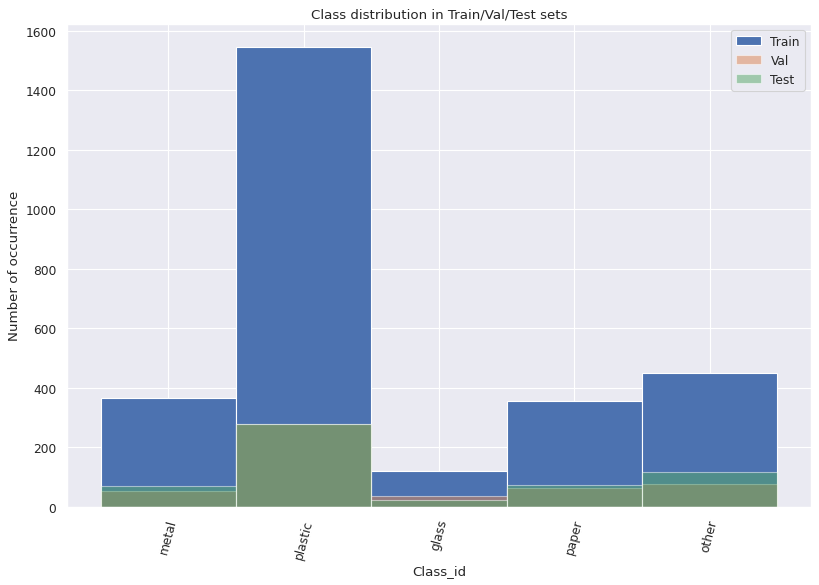

In [ ]:
# Visual check of train-test split
# distribution of classes should be similar in train/test/val

def list_add(list1, list2): 
  return [sum(x) for x in zip(list1, list2)]

def vis(img_id_list):
  vis=[0]*nr_class
  for i in img_id_list:
    X = open('./dataset/labels/'+str(i)+'.txt','r')
    lines = X.readlines()
    classes = [int(line.split()[0]) for line in lines]
    x_ = pd.DataFrame([Counter(classes)],columns=[*range(nr_class)]).fillna(0).astype(int).iloc[[0]].squeeze().tolist()
    vis=list_add(vis,x_)
  return vis

from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)

plt.bar([*range(nr_class)],vis(train_ids), width = 1, label = 'Train')
plt.bar([*range(nr_class)],vis(val_ids), width = 1, label = 'Val',alpha = 0.5)
plt.bar([*range(nr_class)],vis(test_ids), width = 1, label = 'Test',alpha = 0.5)

plt.xticks([0,1,2,3,4],['metal','plastic','glass','paper','other'],rotation = 75)
plt.xlabel("Class_id")
plt.ylabel("Number of occurrence")
plt.title("Class distribution in Train/Val/Test sets")
plt.legend()
plt.show()

In [ ]:
# reorganize data folders as YOLO has special requirements on folder structure
def move_helper(ids, desti):
  for id in ids:
    img_name = os.path.join( './dataset/images', str(id)+'.jpg' )
    lbl_name = os.path.join( './dataset/labels', str(id)+'.txt' )
    #print(img_name)
    if os.path.isfile(img_name):
        shutil.copy( img_name, './dataset/images/'+desti)
        shutil.copy( lbl_name, './dataset/labels/'+desti)
    else :
        print('file does not exist', img_name)

!mkdir dataset/images/{train,val,test}
!mkdir dataset/labels/{train,val,test}

move_helper(test_ids,'test')
move_helper(train_ids,'train')
move_helper(val_ids,'val')


# 3. Hyper-parameter setting

In [ ]:
%cd /content/yolov5

/content/yolov5


In [ ]:
#@title data yml

# specify class names and dataset filepath

with open('/content/yolov5/data/TACO.yaml', mode='w') as fp:
  lines = '''path: /content/dataset  # dataset root dir
train: images/train  # train images 
val: images/val  # val images 
test: images/test # test images (optional)

# Classes
names:
  0: metal
  1: plastic
  2: glass
  3: paper
  4: other
'''
  fp.writelines(lines)

In [ ]:
#@title hyperparameter

# define hypter-parameters
with open('./data/hyps/hyps.yaml', mode='w') as fp:
  lines = """# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.5  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.3  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 0.7  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)

fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 10.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.9  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)

mosaic: 1  # image mosaic (probability)
mixup: 1  # image mixup (probability)
copy_paste: 0  # segment copy-paste (probability)


"""
  fp.writelines(lines)

# 4. Training

In [ ]:
# Train
!rm -rf runs/train/* #clean training log folder

# for demo purpose, here we train 2 epochs only
# for real world application, a few hundred epochs at least
# please play with (tune) these parameters

!python train.py --cache ram --weights yolov5x6.pt --data TACO.yaml --imgsz 1280 \
--batch-size 12 --epochs 2 --patience 500 \
--hyp hyp.scratch-high.yaml \
--cos-lr 

train: weights=yolov5x6.pt, cfg=, data=TACO.yaml, hyp=hyp.scratch-high.yaml, epochs=2, batch_size=12, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=True, label_smoothing=0.0, patience=500, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, 

# 5. Visualization of training logs

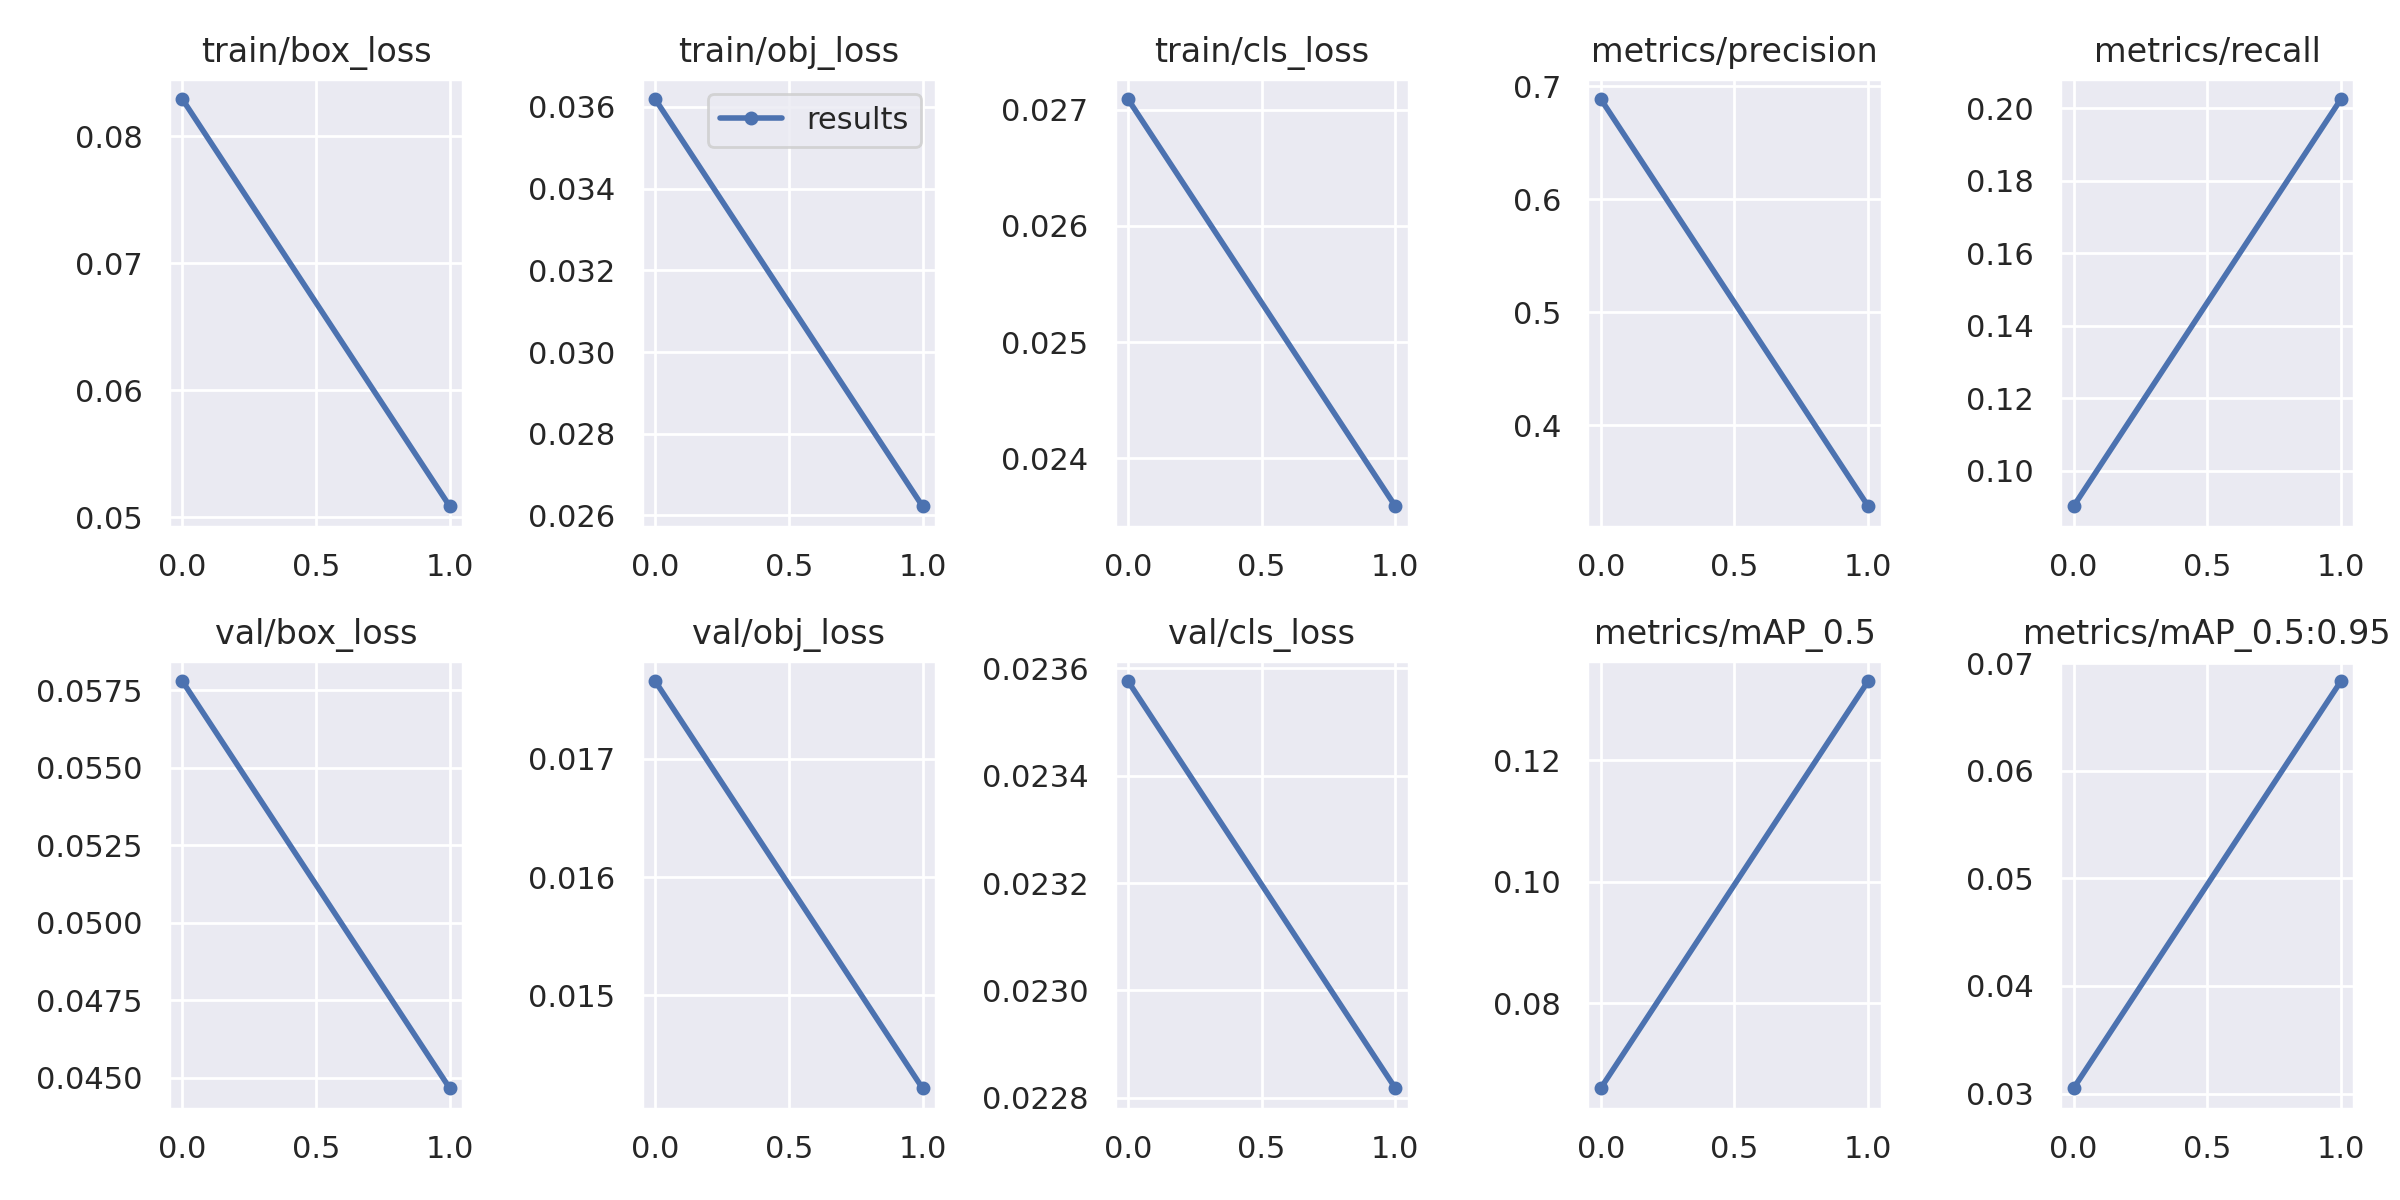

In [ ]:
from IPython import display
display.Image("/content/yolov5/runs/train/exp/results.png")

In [ ]:
# copy training logs & results to your own drive in the foler "yolo_yourname"
%rm -rf /gdrive/MyDrive/yolo_yourname/
%mkdir /gdrive/MyDrive/yolo_yourname/
%cp -r /content/yolov5/runs/train/* /gdrive/MyDrive/yolo_yourname/


In [ ]:
# # you can uncomment this block to have your notebook automatically shut down after training

# from google.colab import runtime
# runtime.unassign()